This Jupyter notebook implements all the analyses presented in the manuscript by Stoll et al (2019), which can be dowloaded from bioRxiv.org [URL].

There are two options to run this notebook.

1) With the corresponding docker image 

An image was created where all necessary files are available. Launch the docker application on your desktop. On a terminal, type:

    docker run -p 8888:8888 -d colomoto/colomoto-docker:next 

Then, on your favorite navigator, open: http://localhost:8888 The notebook can be found in the folder: usecases/UpPMaBoSS.

2) By creating a conda environment locally 

We suggest to download miniconda3 and create an environment named umb with the following command:

    conda create -n umb -c colomoto pymaboss notebook seaborn 

To launch this environment, you need to activate it with the following command before launching the jupyter notebook: 

    conda activate umb
    jupyter notebook


In this notebook, we study the cell population behavior when varying the parameter value related to the time step (max_time in the cfg file), where the chosen values have to be smaller than the first extremum. 


The model used as an example in this notebook is a logical model of the cell fate decision process in response to death receptor activation (TNF and FasL). The logical model was adapted for our purposes from Calzone et al. (2010, PLoS Comp Biol.).

The full analysis of the population model and the effect of TNF can be found in the notebook "CellFateModel_uppmaboss.ipynb". In this notebook, the focus is on the appropriate choice of parameters to perform appropriate in silico simulations: we explore the effect of varying the time step (max_time) on the response to TNF treatment at the level of the cell population.

The files needed for running this example are:

- CellFateModel_uppmaboss.bnd;
- CellFateModel_uppmaboss.cfg;
- CellFateModel_uppmaboss.upp.

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import os

import maboss
import subprocess

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

# Simulation of the wild type model with TNF activation

## MaBoSS run for finding first transient effect

A first simulation of the logical model is done using MaBoSS and for the length of the whole treatment: 48 hours. 
The purpose here is to see how the population behaves without population updates and find the correct time window during which the first events occur (first extremum).

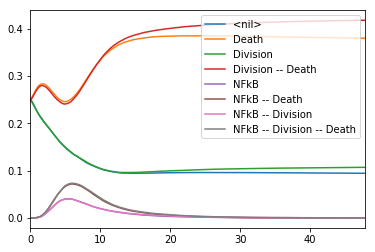

In [2]:
# Set up the example files
bnd_file ="CellFateModel_uppmaboss.bnd"
cfg_WT = "CellFateModel_uppmaboss.cfg"
upp_file = "CellFateModel_uppmaboss.upp"
workdir  = "WT"

# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})

model_48h.network.set_output(('Death','Division','NFkB'))
run_48h = model_48h.run()

run_48h.get_states_probtraj().plot()

## UpPMaBoSS runs, with different values of time steps

According to the results of the WT simulation, we choose to consider the Time Step <= 1, because the first local extremum is around time = 1 hour.

No matter what the max_time is, the total simulation time is 48 hours. Thus, for each max_time, the number of time steps must be adapted. To assess the cell population response with respect to different values for the max_time, we perform UpPMaBoSS simulations for the four cases:

    if max_time is 1, then the number of steps is 48 (black curve)
    if max_time is 1/2, then the number of steps is 96 (red curve)
    if max_time is 1/3, then the number of steps is 144 (blue curve)
    if max_time is 1/4, then the number of steps is 192 (green curve)

Since we are simulating four cases, four subfolders will be created.

The population ratio for each case will be plotted.

Simulations for time step: 1.0
Simulations for time step: 0.5
Simulations for time step: 0.3333333333333333
Simulations for time step: 0.25


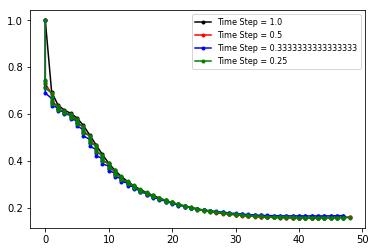

In [3]:
max_time = model_WT.param["max_time"]
time_tick = model_WT.param["time_tick"]

ratios = {1: "black", 2:"red", 3:"blue", 4:"green"}
fig, ax = plt.subplots()
for ratio,color in ratios.items():
    print("Simulations for time step:", str(1/ratio))
    # Update the max step and time tick based on the WT model
    params = {
        'max_time': "%g" % (max_time/ratio),
        "time_tick": "%g" % (time_tick/ratio)
    }
    step_model = maboss.copy_and_update_parameters(model_WT, params)

    # Run UpPMaBoSS on the modified setup
    rwd = "%s_R%s" % (workdir, ratio)
    uppModel_step = maboss.UpdatePopulation(step_model, upp_file)
    
  
    uppModel_step.setStepNumber(48*ratio)
    
    run_step = uppModel_step.run(rwd)
    pop_ratios = run_step.get_population_ratios()
    #pop_ratios = pop_ratios[1:]
    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)


ax.legend(loc='upper right',prop={'size':8})
plt.show()

The asymptotic behavior of the cell population is robust, but the time to reach the asymptotic behavior varies. 

# Simulation of the wild type model with no TNF

## MaBoSS run for finding first transient effect

The same simulations are performed in the case when TNF is not activate (corresponding to "No Pulse TNF" described in the main text).

We perform these simulations on this second situation because the population grows faster than when TNF is ON.

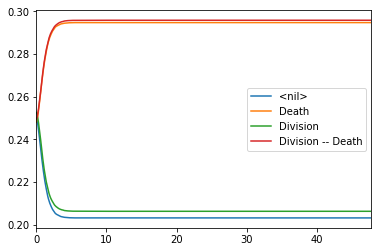

In [4]:
#Create a model for 48h with no TNF

model_48h_noTNF = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
model_48h_noTNF.network.set_istate('TNF',[1,0])

for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h_noTNF.network[name].is_internal = True

model_48h_noTNF.network.set_output(('Death','Division','NFkB'))
run_48h_noTNF = model_48h_noTNF.run()

run_48h_noTNF.get_states_probtraj().plot()

The simulation shows that the asymptotic solution is reached very fast and the window of variation is very small (between 0.2 and 0.3). Note that NFkB is not shown because it is always at 0. We select the same time step as the simulations for TNF ON: Time Step <= 1.

## UpPMaBoSS runs, with different values of update time

Similarly, we explore values for the four cases:

- if max_time is 1, then the number of steps is 48 (black curve)
- if max_time is 1/2, then the number of steps is 96 (red curve)
- if max_time is 1/3, then the number of steps is 144 (blue curve)
- if max_time is 1/4, then the number of steps is 192 (green curve)

Since we are simulating four cases, four subfolders will be created.

The population ratio for each case will be plotted.

Simulations for time step: 1.0
Simulations for time step: 0.5
Simulations for time step: 0.3333333333333333
Simulations for time step: 0.25


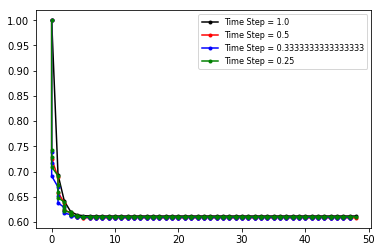

In [5]:
model_WT_noTNF = model_WT.copy()
model_WT_noTNF.network.set_istate('TNF',[1.0,0.0])
ratios = {1: "black", 2:"red", 3:"blue", 4:"green"}
fig, ax = plt.subplots()

upp_sims = []

for ratio,color in ratios.items():
    print("Simulations for time step:", str(1/ratio))
    # Update the max step and time tick based on the WT model
    params = {
        'max_time': "%g" % (max_time/ratio),
        "time_tick": "%g" % (time_tick/ratio)
    }
    step_model_noTNF = maboss.copy_and_update_parameters(model_WT_noTNF, params)

    
    # Run UpPMaBoSS on the modified setup
    rwd = "%s_noTNF_R%s" % (workdir, ratio)
    #uppModel_step_noTNF = maboss.UpdatePopulation(step_model_noTNF, step_upp_file)
    uppModel_step_noTNF = maboss.UpdatePopulation(step_model_noTNF, upp_file)
    uppModel_step_noTNF.setStepNumber(48*ratio)
    
    run_step_noTNF = uppModel_step_noTNF.run(rwd)
    upp_sims.append(run_step_noTNF)
    
    
    pop_ratios = run_step_noTNF.get_population_ratios()
    #pop_ratios = pop_ratios[1:]

    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)


ax.legend(loc='upper right',prop={'size':8})
plt.show()


The different time step values show very little differences. 

A plot of the behavior between time = 0 and time = 10 is shown below.

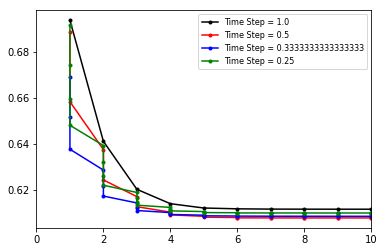

In [6]:
fig, ax = plt.subplots()
for i, (ratio,color) in enumerate(ratios.items()):
    pop_ratios = upp_sims[i].get_population_ratios()
    pop_ratios = pop_ratios[1:]
    
    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)
plt.xlim(0,10)
ax.legend(loc='upper right',prop={'size':8})
plt.show()
